In [1]:
import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from landmarks_datasets import LandmarksMaskDataset
from landmarks_transforms import Transforms, UnNormalize
from Models import Unet_dict, NestedUNet, U_Net, R2U_Net, AttU_Net, R2AttU_Net
from brokenaxes import brokenaxes

torch.cuda.empty_cache()


KeyboardInterrupt



In [2]:


dataset = LandmarksMaskDataset(Transforms())
dataset.NoTransF()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

c:\Projects\msc_haar\git_segnet\Landmark-detection-for-tsetse-fly-wings\landmarks_datasets.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


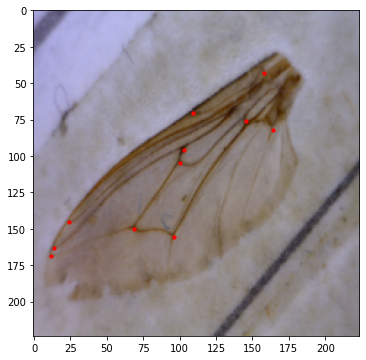

In [4]:
image_, landmarks, mask = dataset[1]
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)

landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
image = image_.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,6))
plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')

In [ ]:
model_Inputs = [U_Net, R2U_Net, AttU_Net, R2AttU_Net, NestedUNet]


def model_unet(model_input, in_channel=3, out_channel=1):
    model_test = model_input(in_channel, out_channel)
    return model_test

#passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary
network = model_unet(model_Inputs[4], 3, 11)

network.load_state_dict(torch.load('C:/Projects/msc_haar/git_segnet/Landmark-detection-for-tsetse-fly-wings/saved_models/model_unet-anneal_segment_finetune_TransF_0.pth', map_location=torch.device('cpu')))




In [6]:
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=None, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)



The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


In [7]:
def get_predicted_landmarks(predicted_masks):
    landmarks = []
    for mask in predicted_masks[0]:
        prediction_s = mask.cpu().numpy()
        seventh_max = np.sort(prediction_s.flatten())[-7]

        mask_indices = np.argwhere(prediction_s >= seventh_max) 
        landmark = np.mean(mask_indices, axis=0)
        landmarks.append([landmark[1]*1280/224, landmark[0]*1024/224])
#         landmarks.append([landmark[1], landmark[0]])
        
    return torch.from_numpy(np.array(landmarks))


def get_predicted_masks(predicted_masks):
    masks = []
    for mask in predicted_masks:
        prediction_s = mask#.cpu().numpy()
#         print("Prediction s 1", prediction_s.shape)
        seventh_max = np.sort(prediction_s.flatten())[-7]
        prediction_s[prediction_s < seventh_max] = 0
        prediction_s[prediction_s >= seventh_max] = 1
        
#         print("Prediction s", prediction_s.shape)
        masks.append(prediction_s)
    return masks

In [8]:
dataset.NoTransF()
start_time = time.time()


#best_network.cuda() 

network.eval()

predictions = torch.zeros(484, 11, 2).detach()
landmarks = torch.zeros(484, 11, 2).detach()
image_plot = 0
#images, landmarks = next(iter(test_loader))
images_plot = []
counter = 0
print("evaluating on test set")
with torch.no_grad():
    for images, landmark, masks in test_loader:
#         print("shape", images.shape)
#         break
        images = images.reshape((1,3,224,224)).cuda()
        image_plot = images[-1].cpu().numpy() if counter == 0 else image_plot
        images_plot.append(images)
#         landmark = ((landmark + 0.5 )*torch.tensor([224, 224])).cuda()
        landmark = ((landmark + 0.5 )*torch.tensor([1280, 1024])).cuda()
        masks = masks.cuda()
        # why the + 0.5
#         prediction = network(images)['out']
        prediction = network(images)
#         plot_prediction = prediction[0].cpu().numpy()
        
#         plot_prediction = get_predicted_masks(plot_prediction)
        j = 0
        
        # Oobtains landmarks form masks
        prediction = get_predicted_landmarks(prediction)

#         for mask in plot_prediction:
# #             print(np.amax(mask))
#             plt.figure()
#             plt.imshow(mask, cmap="gray")
#             plt.scatter(landmark[j][0].cpu().numpy()*224/1280, landmark[j][1].cpu().numpy()*224/1024, s=10, color ='r')
#             plt.scatter(prediction[j][0].cpu().numpy()*224/1024, prediction[j][1].cpu().numpy()*224/1280, s=10, color ='y')

#             j+=1
            
#         plt.show()
#         print(prediction.shape)
        
#         prediction = get_predicted_landmarks(masks)

        landmarks[counter,:] = landmark
        predictions[counter,:] = prediction
        predictions.detach()
        counter += 1
endtime = time.time()-start_time
print(endtime)


evaluating on test set
94.92314577102661


mean distance 3.6422813
mean std 3.1444967
11 [ 1  2  3  4  5  6  7  8  9 10 11]


C:\Users\dylan\AppData\Local\Temp/ipykernel_19952/4284491128.py:13: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


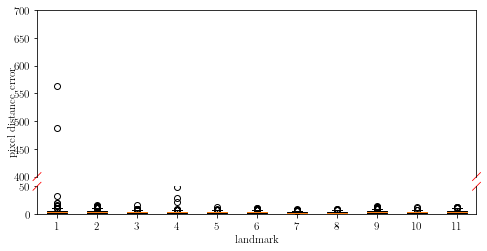

In [12]:
#print(predictions)
difs = abs(predictions - landmarks)
difs = difs.detach()

dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
av = []
for I in dis:
  av.append(np.mean(I.numpy()))
print("mean distance", np.mean(av))
print("mean std",np.std(av))
# print(plt.rcParams.keys())
#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

fig = plt.figure()
# width is 5.251 inches
fig.set_size_inches(5.251*1.5,3.75) 
# fig.set_size_inches(5.251*2,3.75*1.5) 


xticks = [1,2,3,4,5,6,7,8,9,10,11]
print(len(dis.T), np.arange(1,12))
bax = brokenaxes(ylims=((0, 50), (400, 700)), hspace=.1, despine=False, tilt=45, d=0.01, diag_color='r')
bax.boxplot(dis.T)
bax.axs[1].set_xticks(xticks) #xticks does weird stuff without this
bax.set_xlabel('landmark', labelpad=20)
bax.set_ylabel('pixel distance error', labelpad=20)


# plt.boxplot(dis.T)

# plt.xlabel('landmark')
# plt.ylabel('pixel distance error')
# # plt.title('Pixel distance errors')
# plt.ylim([0,45])
plt.savefig('segmentation-boxplot-full.pdf', bbox_inches="tight", dpi=1000)
plt.show()


3.6422813
3.1444967
11 [ 1  2  3  4  5  6  7  8  9 10 11]


C:\Users\dylan\AppData\Local\Temp/ipykernel_9416/1748823904.py:11: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


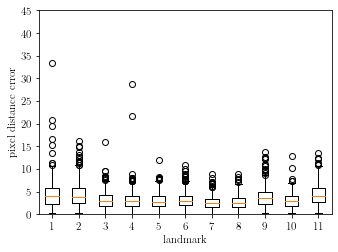

In [9]:
#print(predictions)
difs = abs(predictions - landmarks)
difs = difs.detach()

dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
av = []
for I in dis:
  av.append(np.mean(I.numpy()))
print(np.mean(av))
print(np.std(av))
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

fig = plt.figure()
# width is 5.251 inches
fig.set_size_inches(5.251,3.75) 
# fig.set_size_inches(5.251*2,3.75*1.5) 


xticks = [1,2,3,4,5,6,7,8,9,10,11]
print(len(dis.T), np.arange(1,12))
# bax = brokenaxes(ylims=((0, 45), (45, 565)), hspace=.1, despine=False, tilt=45, d=0.01, diag_color='r')
# bax.boxplot(dis.T)
# bax.axs[1].set_xticks(xticks) #xticks does weird stuff without this
# bax.set_xlabel('landmark', labelpad=20)
# bax.set_ylabel('pixel distance error', labelpad=20)


# # fig.set_size_inches(5.251*2,3.75*1.5)
# plt.figure(figsize=(10,10))
plt.boxplot(dis.T)

plt.xlabel('landmark')
plt.ylabel('pixel distance error')
# plt.title('Pixel distance errors')
plt.ylim([0,45])
plt.savefig('resnet-boxplot.pdf', bbox_inches="tight", dpi=1000)
plt.show()


In [28]:
plot_idx = 35
image_plot = np.transpose(images_plot[plot_idx][0].cpu().numpy(), (1, 2, 0))


In [29]:
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image_plot = unorm(torch.from_numpy(image_plot)).numpy()


image_plot = image_plot - np.amin(image_plot)
image_plot = image_plot/np.amax(image_plot)
print(np.amin(image_plot), np.amax(image_plot))
image_plot = (255*image_plot).astype(np.uint8)

0.0 1.0


In [11]:
print(landmarks.shape)
print((landmarks[:,:,0]**2).shape)

torch.Size([484, 11, 2])
torch.Size([484, 11])


In [18]:

difs = abs(predictions - landmarks)
difs = difs.detach()

dis = difs[:, :,0]**2 + difs[:, :, 1]**2
print(dis.sum(axis=0))
rms = np.sqrt(dis.sum(axis=0)/dis.shape[0])
print(rms)
rms.mean()



tensor([568798.1875,  12920.9482,   6501.6597,   9375.0762,   5909.5391,
          6372.1074,   4117.4824,   4554.6831,   9299.6543,   5730.3950,
         11934.6123])
tensor([34.2812,  5.1668,  3.6651,  4.4011,  3.4943,  3.6284,  2.9167,  3.0677,
         4.3834,  3.4409,  4.9657])


tensor(6.6738)

In [60]:
np.argmax(difs[:,0,0].cpu().numpy())

354

In [10]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.
    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.
        d, Z, [tform] = procrustes(X, Y)
    Inputs:
    ------------
    X, Y
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.
    scaling
        if False, the scaling component of the transformation is forced
        to 1
    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.
    Outputs
    ------------
    d
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()
    Z
        the matrix of transformed Y-values
    tform
        a dict specifying the rotation, translation and scaling that
        maps X --> Y
    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform
def generalized_procrustes(data):
    mean = data[0,...]
    print('Aligning')
    d = 100
    d_old = 100
    while d > 0.0001:
        d_new = 0
        for i in range(data.shape[0]):
            d_, data[i,:], _ = procrustes(mean, data[i,:], scaling=False, reflection=False)
            d_new += d_ / data.shape[0]
        d = d_old - d_new
        d_old = d_new
        mean = data.mean(axis=0)
    return mean

mean = generalized_procrustes(landmarks)

<>:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\dylan\AppData\Local\Temp/ipykernel_9416/2328989054.py:64: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if reflection is not 'best':


Aligning


In [11]:
from scipy.spatial import procrustes as procrustes_ 
procrustes_errors = {'error':[], 'procrustes_disparity':[]}
for i in range(484):
    procrustes_errors['error'].append(av[i])
    mtx1, mtx2, disparity = procrustes_(mean, landmarks[i])
    procrustes_errors['procrustes_disparity'].append(disparity)



In [12]:
proc = []
#for i in procrustes_errors['procrustes_disparity']:
#    if i>0.001:
#        proc.append(i)
errors = []
for it, i in enumerate(procrustes_errors['error']):
    #$print(it)
    mean_err = np.mean(procrustes_errors['error'])
    mean_disp = np.mean(procrustes_errors['procrustes_disparity'])
    std_err = np.std(procrustes_errors['error'])*2
    std_disp = np.std(procrustes_errors['procrustes_disparity'])*2
    i_p = procrustes_errors['procrustes_disparity'][it]
    if (mean_err - std_err)<i<(mean_err + std_err) and (mean_disp-std_disp)<i_p<(mean_disp + std_disp):
        errors.append(i)
        proc.append(procrustes_errors['procrustes_disparity'][it])

In [37]:
len(proc) - len(procrustes_errors['procrustes_disparity'])

-18

In [38]:
18/len(procrustes_errors['procrustes_disparity'])

0.0371900826446281

C:\Users\dylan\AppData\Local\Temp/ipykernel_9416/2893582914.py:53: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


0.01
461.86


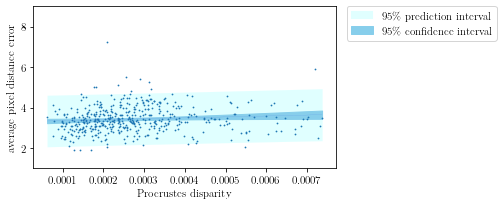

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#weights  = procrustes_errors['procrustes_disparity']

#heights = procrustes_errors['error']

weights  = proc#procrustes_errors['procrustes_disparity']

heights = errors#procrustes_errors['error']

x = weights#/max(weights)

y = heights#/max(heights)
slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = len(x)                       # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
# plt.rcParams.update({'font.size': 11})
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

fig = plt.figure()
# width is 5.251 inches
# fig.set_size_inches(5.251,3.75) 
fig.set_size_inches(5.251,2.81) 

ax = fig.add_axes([.1, .1, .8, .8])

#, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue', linewidth=0.1)
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95\% prediction interval', linewidth=0.1)
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95\% confidence interval')
ax.scatter(x, y, s = 0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

#ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
#ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
# plt.title('Procrustus disparity vs pixel distance error',  fontsize=12)
#plt.ylabel('average pixel distance error')
#plt.xlabel('Procrustes disparity')
#plt.plot([0,0.6],[0.38,0.38], linewidth=0.5, c='g', label = 'Median average pixel distance error')
#plt.plot([0.118,0.118],[0.0,1], linewidth=0.5, c='r', label = 'Median procrustus disparity')
# plt.legend(bbox_to_anchor=(1.55,1.035))
#plt.legend(bbox_to_anchor=(1.55,1.035))
plt.ylim([1,9])
#plt.ylim([0.0,40])
plt.savefig('segmentation-procrustes_400dpi.pdf', bbox_inches="tight", dpi=400)
print(r2s)
print(b)

0.01
461.86


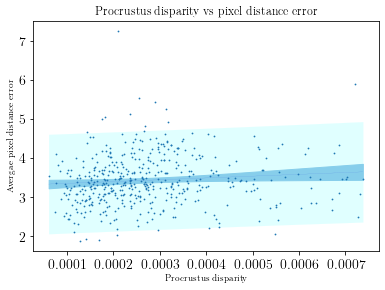

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

weights  = proc#procrustes_errors['procrustes_disparity']

heights = errors#procrustes_errors['error']

x = weights#/max(weights)

y = heights#/max(heights)
slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = len(x)                       # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([.1, .1, .8, .8])

#, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue', linewidth=0.1)
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval', linewidth=0.1)
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')
ax.scatter(x, y, s = 0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

#ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
#ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
plt.title('Procrustus disparity vs pixel distance error',  fontsize=12)
plt.ylabel('Avergae pixel distance error',fontsize=9)
plt.xlabel('Procrustus disparity',fontsize=9)
#plt.plot([0,0.6],[0.38,0.38], linewidth=0.5, c='g', label = 'Median average pixel distance error')
#plt.plot([0.118,0.118],[0.0,1], linewidth=0.5, c='r', label = 'Median procrustus disparity')
#plt.legend( fontsize=8)
#plt.xlim([0.0,0.005])
#plt.ylim([0.0,40])
plt.savefig('linear_reg.png')
print(r2s)
print(b)

Text(0, 0.5, 'Frequency')

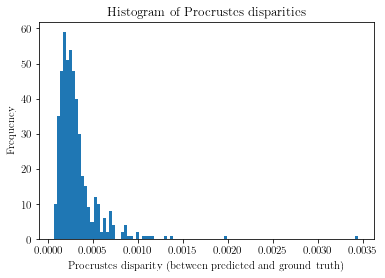

In [38]:
plt.hist(procrustes_errors['procrustes_disparity'], bins = 100)
plt.title('Histogram of Procrustes disparities')
plt.xlabel('Procrustes disparity (between predicted and ground truth)')
# plt.xlim((0,0.0012))
plt.ylabel('Frequency')

In [11]:

from scipy import stats
weights = procrustes_errors['procrustes_disparity']

heights = procrustes_errors['error']
x = weights/max(weights)

y = heights/max(heights)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
p_value

4.9920796331063357e-05